In [1]:
import warnings
import cv2
from PIL import Image
warnings.filterwarnings("ignore")

В этот раз мы познакомимся с задачей детекции. Сделаем это, обучив модель YOLOv5. Это далеко не самая современная модель, но она достаточно близка к тем, которые используются сейчас.

Всего есть два типа моделей детекции: двухэтапные и одноэтапные. Несколько примеров моделей, использующих разные подходы:
- RCNN подход: Предполагает двухэтапный проход модели по изображению, где изначально выделяются зоны способами классического компьютерного зрения, а затем происходит уже знакомая нам классификация объектов в зонах и предсказание с помощью задачи регрессии координат box для объектов. 
- YOLO подход: Одноэтапный детектор удаляет процесс извлечения области интереса и напрямую классифицирует и регрессирует анкерные блоки-кандидаты (anchor-boxes). YOLO — это архитектура детекции, которая называется YOU ONLY LOOK ONCE.Она обучается от от начала до конца, для обработки изображения и прогнозирования ограничивающих рамок (BBox) и меток классов для каждой ограничивающей рамки напрямую. Наверное, наиболее популярная, также лицензия предполгает постоянное появление новых моделей
- Detr - также одноэтапный, однако использующий трансформерную архитектуру и особенный дизайн предсказывающей головы, чтобы уйти от необходимости предсказания анкерных блоков (что довольно затратно), предсказывая объекты сразу. Иронично, но в поздних версиях к анкерам вернулись.

![alt_text](../additional_materials/images/detection_stages.jfif)



In [2]:
!pip install -r https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt

Для начала посмотрим, как модель строит свои предсказания

Using cache found in C:\Users\tosha/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-11-9 Python-3.12.7 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 8192MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
100%|██████████| 49.2k/49.2k [00:00<00:00, 1.17MB/s]
100%|██████████| 134k/134k [00:00<00:00, 1.73MB/s]
image 1/2: 720x1280 2 persons, 1 tie, 1 cell phone
image 2/2: 1080x810 4 persons, 1 bus
Speed: 9.5ms pre-process, 39.8ms inference, 62.5ms NMS per image at shape (2, 3, 640, 640)


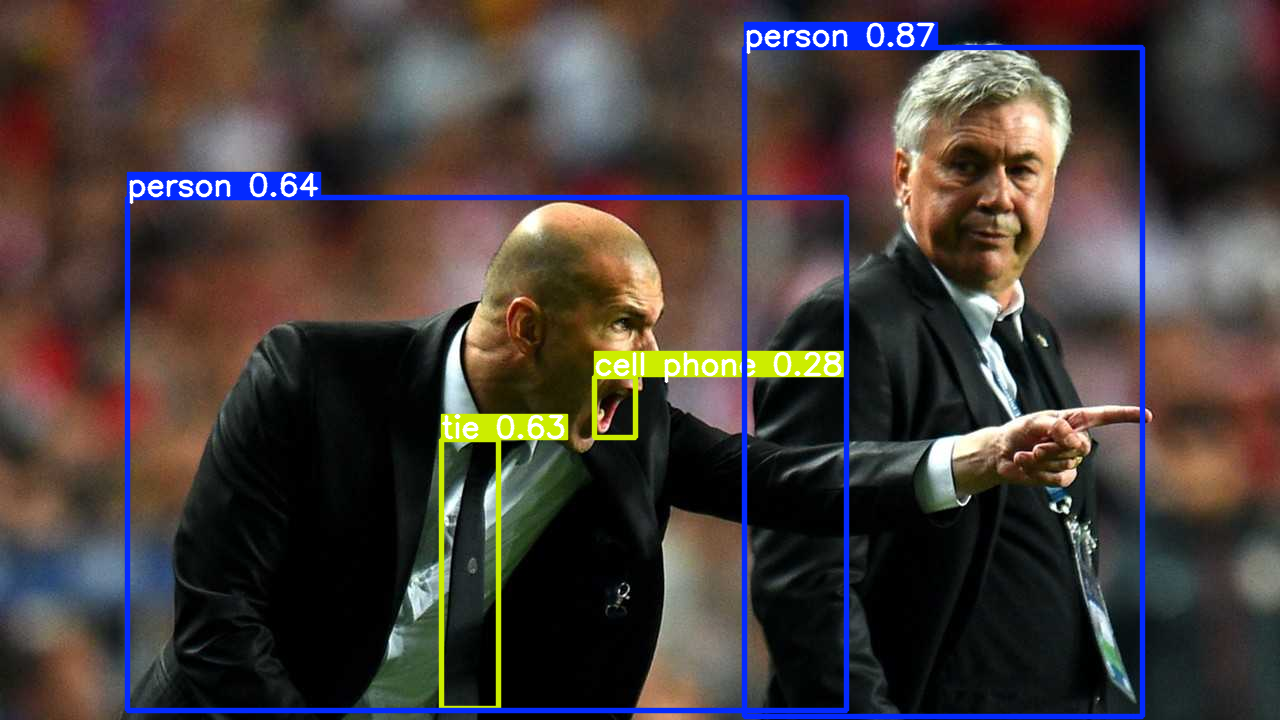

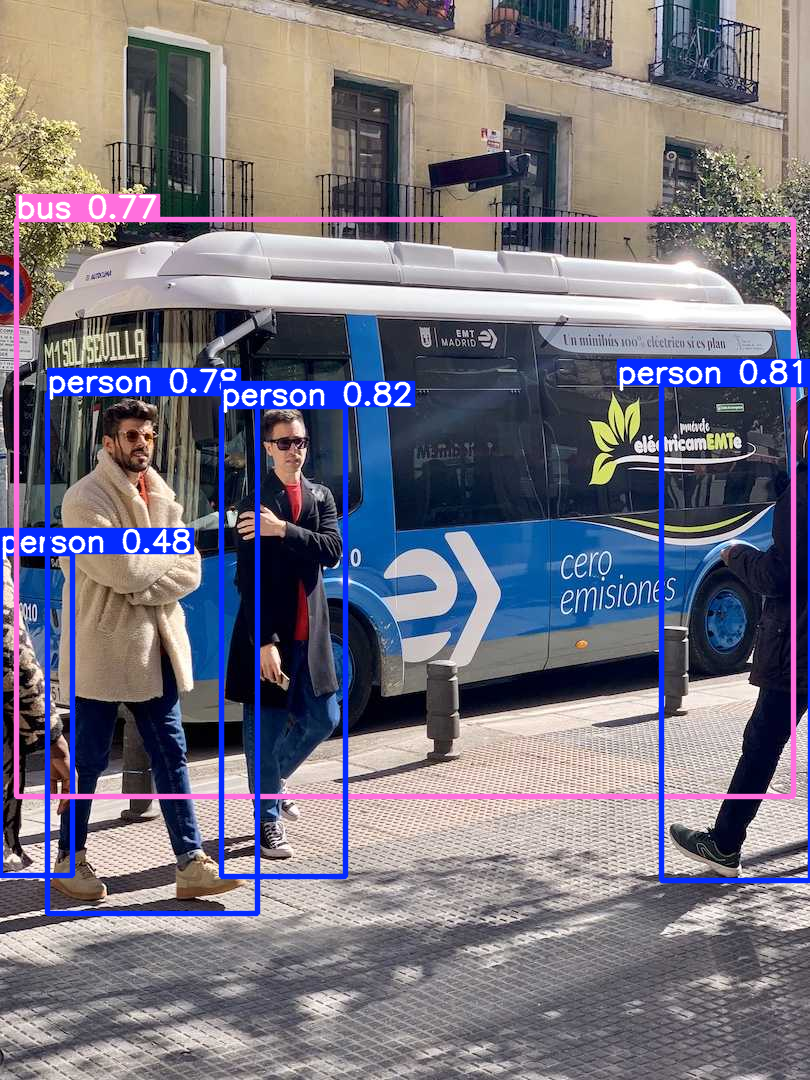

xmin        ymin         xmax        ymax  confidence  class  \
0  744.907104   47.698029  1142.064575  716.603760    0.867562      0   
1  127.908997  197.587555   846.010132  710.413818    0.637405      0   
2  441.281921  439.584229   498.370300  708.050049    0.634788     27   
3  594.012390  376.764648   635.621521  437.114990    0.276906     67   

         name  
0      person  
1      person  
2         tie  
3  cell phone

In [3]:
import torch

model = torch.hub.load("ultralytics/yolov5", "yolov5s")
im = "https://ultralytics.com/images/zidane.jpg"

for f in "zidane.jpg", "bus.jpg":
    torch.hub.download_url_to_file("https://ultralytics.com/images/" + f, f)  # download 2 images
im1 = Image.open("zidane.jpg")  # PIL image
im2 = cv2.imread("bus.jpg")[..., ::-1]  # OpenCV image (BGR to RGB)

results = model([im1, im2], size=640)  # batch of images
results.print()
results.show()

results.pandas().xyxy[0]

Другой способ загрузить предобученную модель - загрузить с хаба YOLO. 

In [4]:
from ultralytics import YOLO
model = YOLO("yolo11n.pt")  # load a pretrained model (recommended for training)

In [5]:
results = model([im1, im2])  # batch of images


0: 640x640 2 persons, 1 tie, 42.8ms
1: 640x640 4 persons, 1 bus, 42.8ms
Speed: 6.0ms preprocess, 42.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


In [6]:
import supervision as sv
detections = sv.Detections.from_ultralytics(results[0])
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK)

annotated_image = im1.copy()
annotated_image = box_annotator.annotate(annotated_image, detections=detections)
annotated_image = label_annotator.annotate(annotated_image, detections=detections)

sv.plot_image(annotated_image, size=(10, 10))

Как устроена модель: 

- **Backbone** - это основная часть сети. Для YOLOv5 бекбон спроектирован с использованием CSP-Darknet53 — модификации архитектуры Darknet, использовавшейся в предыдущих версиях.
- **Neck**: Эта часть соединяет backbone и head. В YOLOv5 используются структуры SPPF и New CSP-PAN.
- **Head**: Эта часть отвечает за конечный результат. Она генерирует предсказанные bbox-ы.


У YOLO длинная история. Рассмотрим некоторые основные идеи. 
![alt_text](../additional_materials/images/yolo_evolution.png)

Мы сегодня рассмотрим основные вещи YOLOv5, попробуем ее и YOLOv11. 
Итак, общая архитектура YOLOv5 показана ниже:
![alt_text](../additional_materials/images/YOLOv5-1.png).

Какие важные идеи были использованы? 
Первое - SCPNet (Cross Stage Partial Network). Это важная часть, которая довольно долго тянется в YOLO для того, чтобы управлять протеканием градиентов. Чуть раньше перед этим была придумана DenseNet как ультра-версия резнета ( все блоки соединены со всеми), и из нее выросла идея конкатенировать выходы блоков с более поздними. Это было добавлено в YOLO4, показало эффективность и используется в некотором виде до сих пор. 

![alt_text](../additional_materials/images/yolo_back.png).

Второе - Spatial Pyramid pooling. Этот вид пулинга берет входы с разных этапов прохода по сети и объединяет ыместе конкатенацией, что похволяет находить объекты разных размеров.

![alt_text](../additional_materials/images/sppf.jfif).

Обучение проводится за один шаг, а не в несколько этапов. В YOLOv5 функция лосса была следующей:
![alt_text](../additional_materials/images/det_loss.svg)

Она содержит: 
- Classes Loss (BCE Loss): Бинарная кросс-энтропия для классификации категорий
- Objectness Loss (BCE Loss): Еще одна кросс-энтропия, которая позволяет определить, есть ли объект в предсказанном bbox-е.
- Location Loss (CIoU Loss): Complete IoU loss, определяет ошибку локализации в гриде
Кроме того, функция потерь взвешивается для разных размеров объектов: $L = w_{big} * L_{big} + w_{medium} * L_{medium} + w_{small} * L_{small} $



Как строятся обучающие датасеты? У YOLO свой формат,описывающий изображения следующим образом: 
Рассмотрим пример картинки: 

![alt_text](../additional_materials/images/two-persons-tie.avif)

Она содержит два объекта. Каждому из них соответствует bbox и класс. 
Они сохраняются в файл с разметкой вида: 
<img src="../additional_materials/images/two-persons-tie-1.avif" alt="drawing" width="500"/>

Датасет же организуется так как указано ниже:
```
../datasets/coco128/images/im0.jpg  # image
../datasets/coco128/labels/im0.txt  # label
```
Другой часто использующийся формат датасета - COCO. Пример ниже:
```json
{
    "info": {
        "description": "COCO 2017 Dataset",
        "url": "http://cocodataset.org",
        "version": "1.0",
        "year": 2017,
        "contributor": "COCO Consortium",
        "date_created": "2017/09/01"
    },
    "licenses": [
        {"url": "http://creativecommons.org/licenses/by/2.0/","id": 4,"name": "Attribution License"}
    ],
    "images": [
        {"id": 242287, "license": 4, "coco_url": "http://images.cocodataset.org/val2017/xxxxxxxxxxxx.jpg", "flickr_url": "http://farm3.staticflickr.com/2626/xxxxxxxxxxxx.jpg", "width": 426, "height": 640, "file_name": "xxxxxxxxx.jpg", "date_captured": "2013-11-15 02:41:42"},
        {"id": 245915, "license": 4, "coco_url": "http://images.cocodataset.org/val2017/nnnnnnnnnnnn.jpg", "flickr_url": "http://farm1.staticflickr.com/88/xxxxxxxxxxxx.jpg", "width": 640, "height": 480, "file_name": "nnnnnnnnnn.jpg", "date_captured": "2013-11-18 02:53:27"}
    ],
    "annotations": [
        {"id": 125686, "category_id": 0, "iscrowd": 0, "segmentation": [[164.81, 417.51,......167.55, 410.64]], "image_id": 242287, "area": 42061.80340000001, "bbox": [19.23, 383.18, 314.5, 244.46]},
        {"id": 1409619, "category_id": 0, "iscrowd": 0, "segmentation": [[376.81, 238.8,........382.74, 241.17]], "image_id": 245915, "area": 3556.2197000000015, "bbox": [399, 251, 155, 101]},
        {"id": 1410165, "category_id": 1, "iscrowd": 0, "segmentation": [[486.34, 239.01,..........495.95, 244.39]], "image_id": 245915, "area": 1775.8932499999994, "bbox": [86, 65, 220, 334]}
    ],
    "categories": [
        {"supercategory": "speaker","id": 0,"name": "echo"},
        {"supercategory": "speaker","id": 1,"name": "echo dot"}
    ]
}
```

Как модели обучают? Можно, как обычно в torch, создать датасет и обучить модель, используя кастомные лоссы. Впрочем, в ultralitics есть готовые функции для этого, нужно лишь подготовить датасет.


Загрузим датасет. Это датасет, содержащий объекты и персонажей apex legends. Этот датасет - один из публичных датасетов roboflow, воспользуемся им.

In [7]:
from roboflow import Roboflow
rf = Roboflow(api_key="04jfNo72GtzXzPTSysbN")
project = rf.workspace("roboflow-100").project("apex-videogame")
version = project.version(2)
dataset = version.download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


Дообучим модель. Обучать ее с нуля для нас нет смысла. Попробуем дообучить 2 эпохи.

In [10]:
results = model.train(data="apex-videogame-2/data.yaml", epochs=2, imgsz=640)

Ultralytics 8.3.36  Python-3.12.7 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolo11n.pt, data=apex-videogame-2/data.yaml, epochs=2, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train18, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, sh

100%|██████████| 755k/755k [00:00<00:00, 1.67MB/s]

Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                


  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  8                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  9                  -1  1    164608  ultralytics.nn.modules.block.SPPF            [256, 256, 5]                 
 10                  -1  1    249728  ultralytics.nn.modules.block.C2PSA           [256, 256, 1]                 
 11                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 12             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

train: Scanning C:\Users\tosha\PycharmProjects\spbu_deep_learning\notebooks\apex-videogame-2\train\labels... 2583 images, 11 backgrounds, 0 corrupt: 100%|██████████| 2583/2583 [00:02<00:00, 1085.68it/s]


train: New cache created: C:\Users\tosha\PycharmProjects\spbu_deep_learning\notebooks\apex-videogame-2\train\labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning C:\Users\tosha\PycharmProjects\spbu_deep_learning\notebooks\apex-videogame-2\valid\labels... 691 images, 1 backgrounds, 0 corrupt: 100%|██████████| 691/691 [00:00<00:00, 786.05it/s]


val: New cache created: C:\Users\tosha\PycharmProjects\spbu_deep_learning\notebooks\apex-videogame-2\valid\labels.cache
Plotting labels to runs\detect\train18\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train18
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2      2.38G      2.117      3.534      1.787         16        640: 100%|██████████| 162/162 [00:25<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.61it/s]

                   all        691        828      0.329      0.274      0.222      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2      2.38G      1.602      2.086      1.362          7        640: 100%|██████████| 162/162 [00:21<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:05<00:00,  4.34it/s]


                   all        691        828      0.601      0.468      0.495      0.253

2 epochs completed in 0.017 hours.
Optimizer stripped from runs\detect\train18\weights\last.pt, 5.5MB
Optimizer stripped from runs\detect\train18\weights\best.pt, 5.5MB

Validating runs\detect\train18\weights\best.pt...
Ultralytics 8.3.36  Python-3.12.7 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 8192MiB)
YOLO11n summary (fused): 238 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.35it/s]


                   all        691        828      0.604      0.468      0.496      0.253
                avatar        637        704      0.681      0.639      0.674      0.341
                object        112        124      0.527      0.297      0.319      0.165
Speed: 0.2ms preprocess, 1.9ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs\detect\train18


Обратите внимание, как быстро обучается модель. Большой плюс YOLO - ее быстродействие. Результаты обучения сохраняются в файлы, их можно посмотреть после обучения. Посмотрим же. 

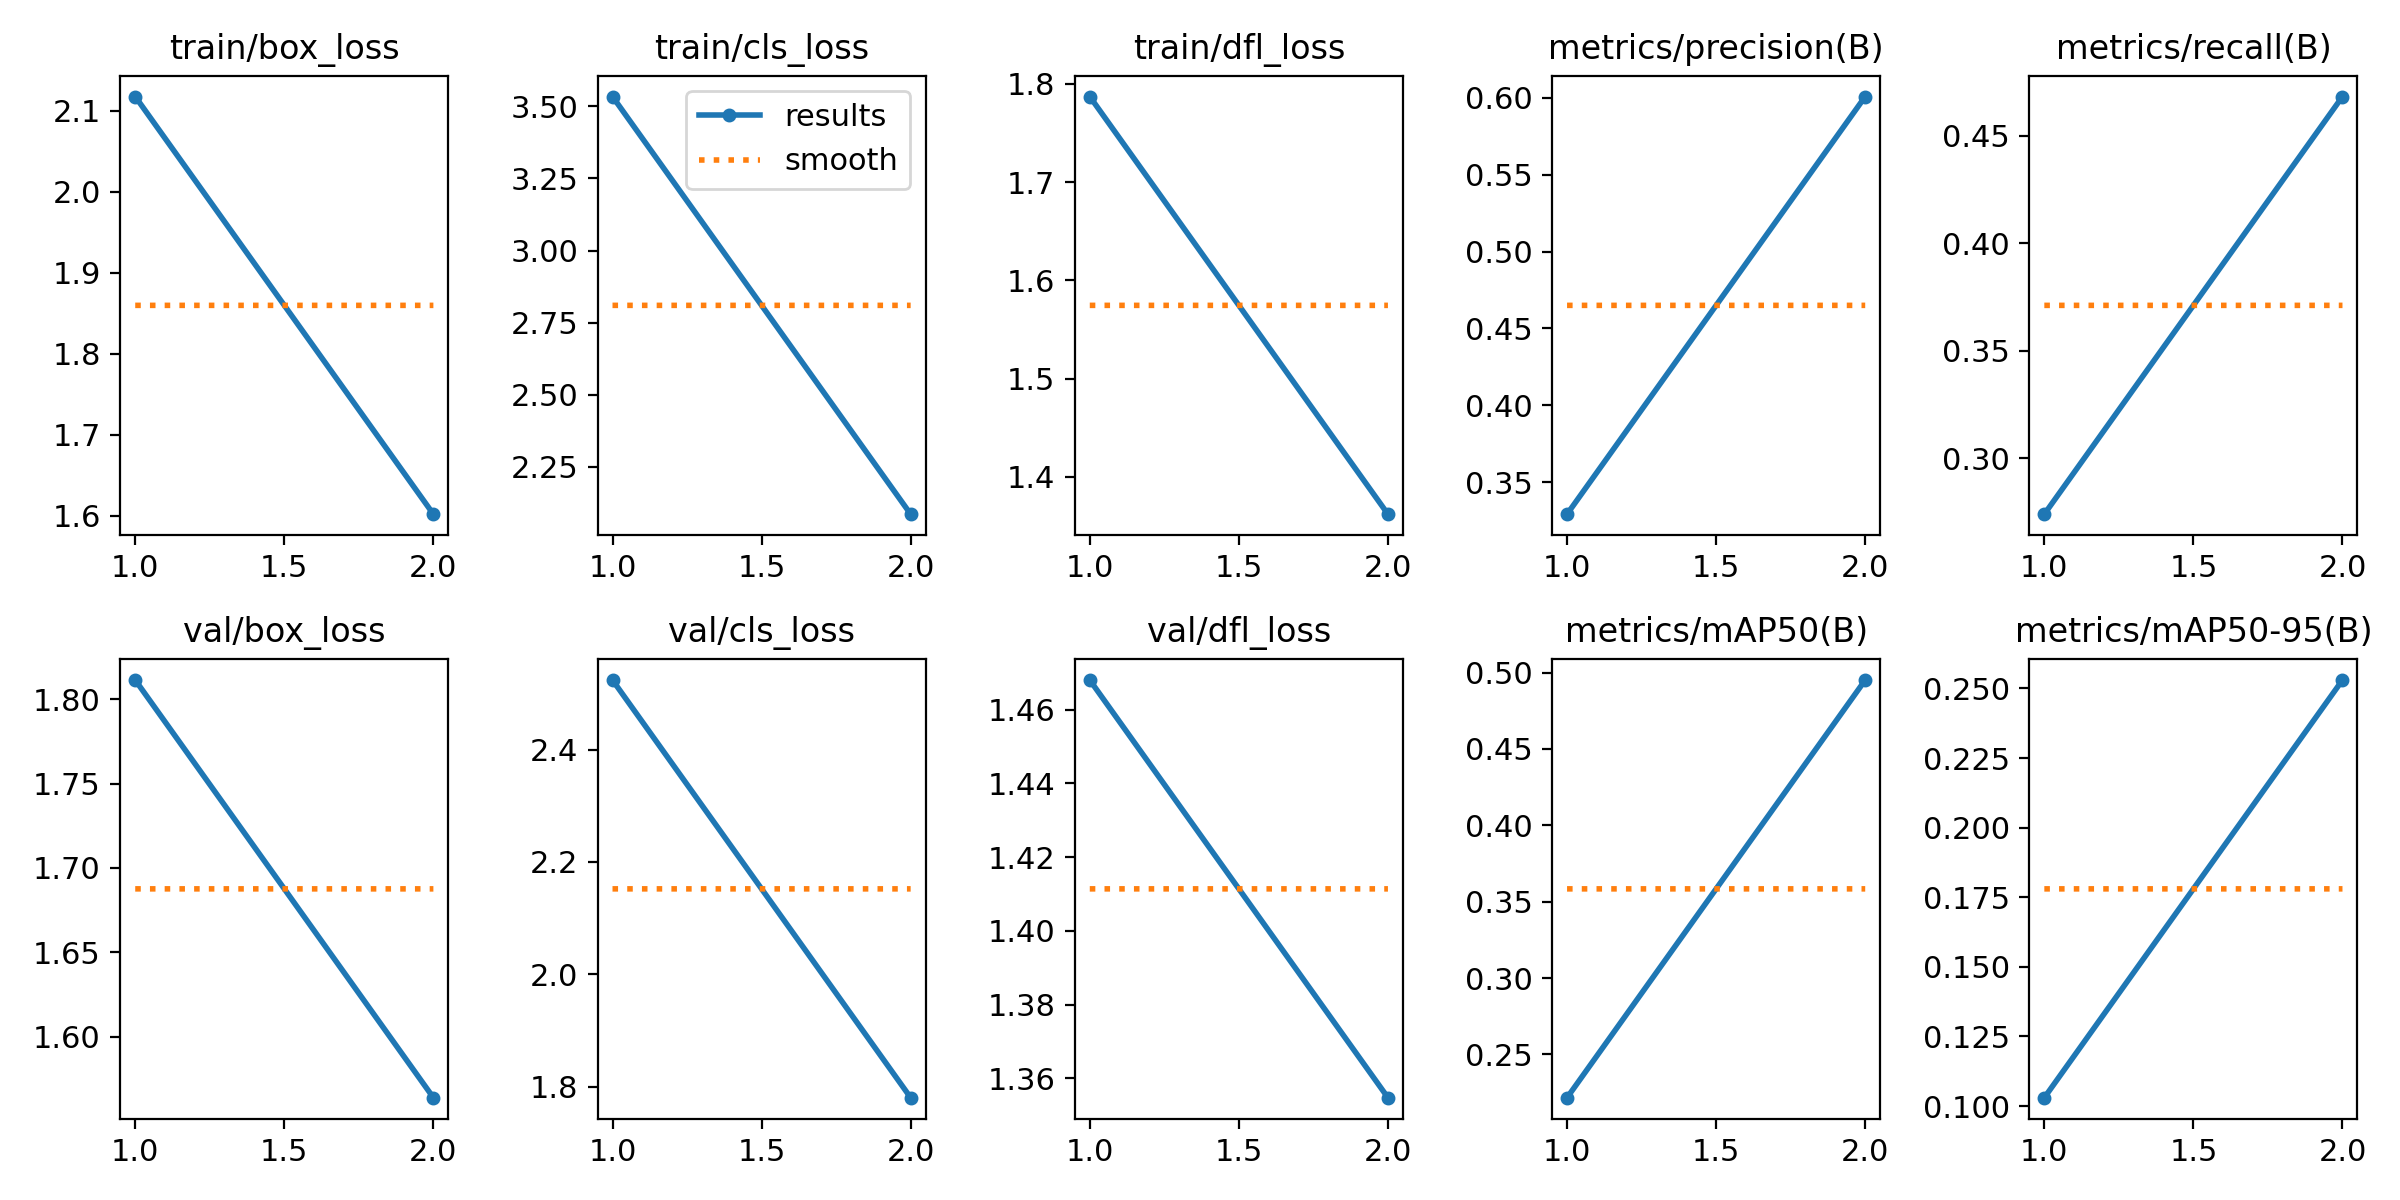

In [14]:
from IPython.display import Image as IPyImage
filename = r"./runs/detect/train18/results.png"
IPyImage(filename=filename, width=600)

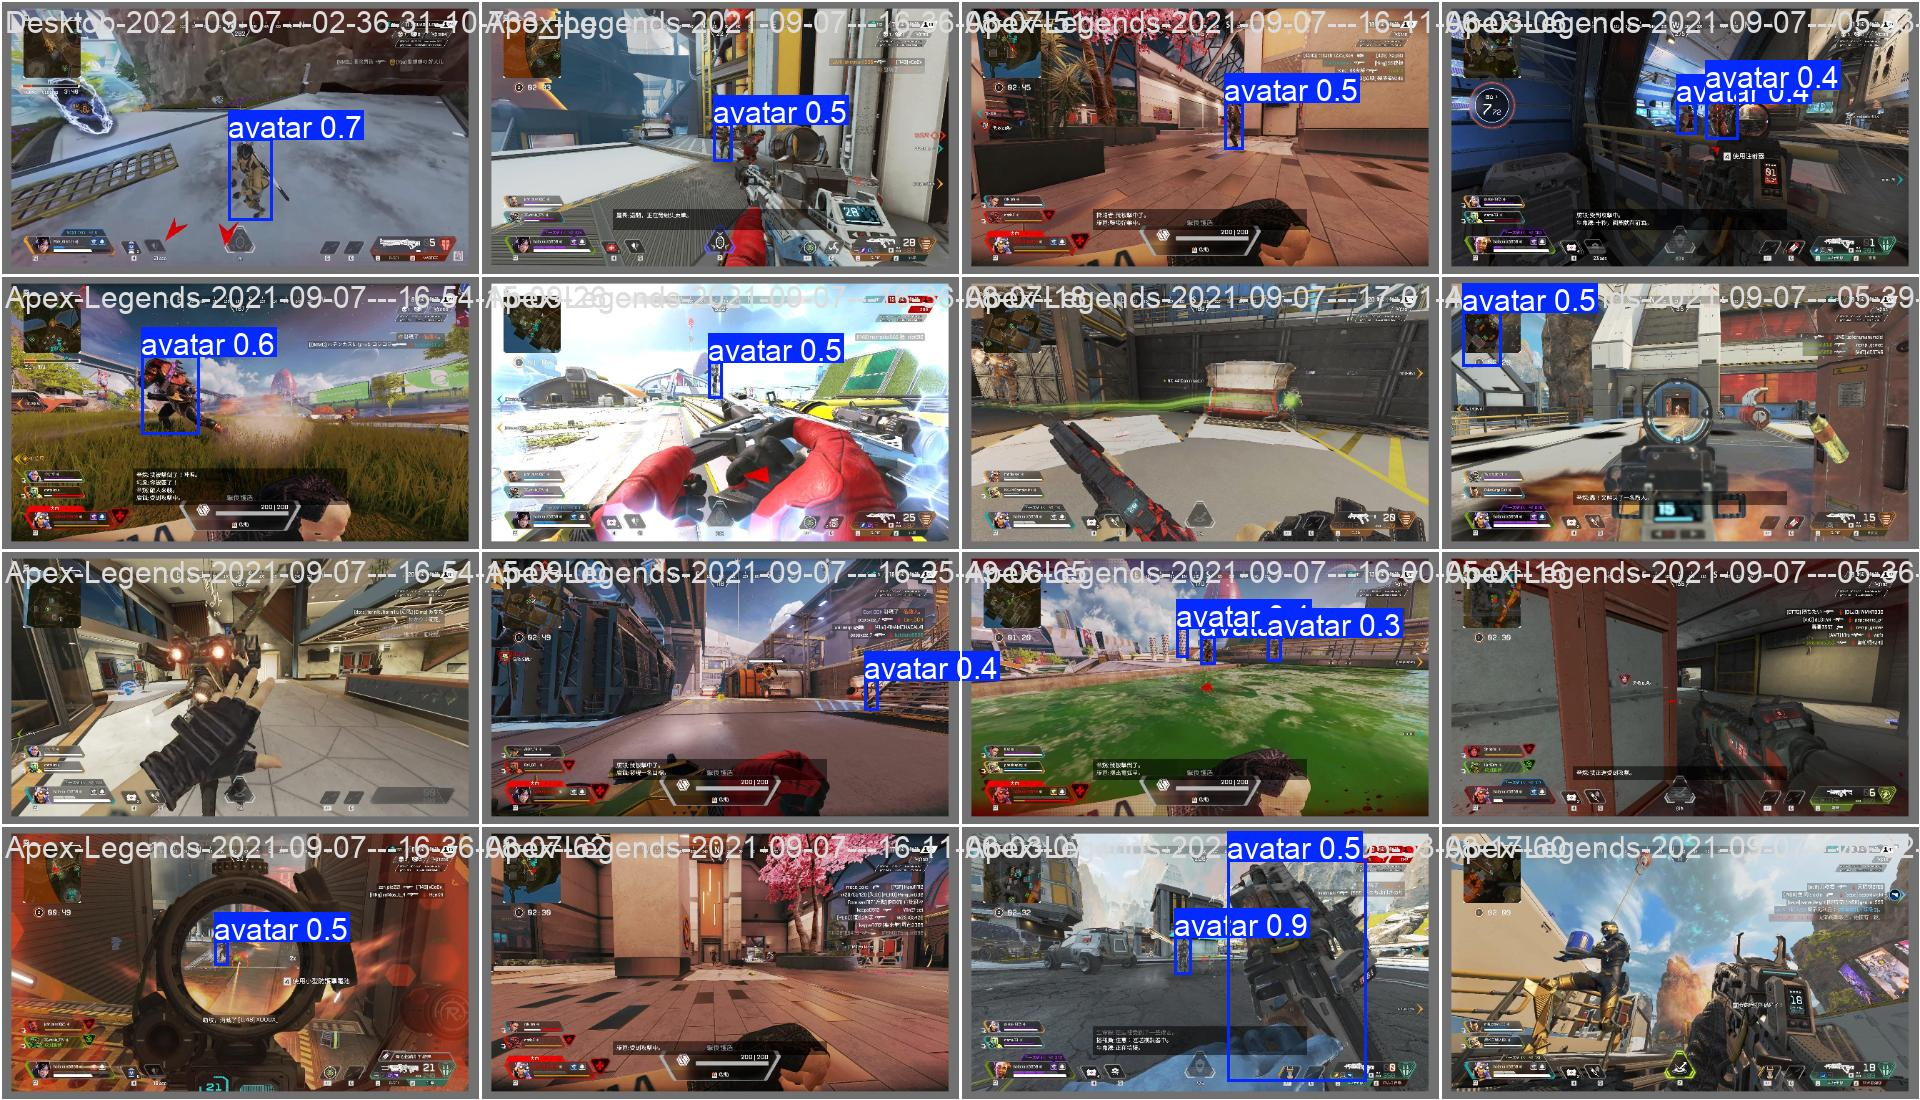

In [16]:
filename = r"./runs/detect/train18/val_batch0_pred.jpg"
IPyImage(filename=filename, width=600)

Провалидируем модель: 

In [20]:
!yolo task=detect mode=val model="C:/Users/tosha/PycharmProjects/spbu_deep_learning/notebooks/runs/detect/train18/weights/best.pt" data={dataset.location}/data.yaml

Ultralytics 8.3.36 🚀 Python-3.12.7 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 8192MiB)
YOLO11n summary (fused): 238 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs
                   all        691        828      0.596      0.465      0.496      0.254
                avatar        637        704      0.677      0.641      0.675      0.342
                object        112        124      0.516       0.29      0.318      0.167
Speed: 0.4ms preprocess, 3.1ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs\detect\val
💡 Learn more at https://docs.ultralytics.com/modes/val



val: Scanning C:\Users\tosha\PycharmProjects\spbu_deep_learning\notebooks\apex-videogame-2\valid\labels.cache... 691 images, 1 backgrounds, 0 corrupt: 100%|██████████| 691/691 [00:00<?, ?it/s]
val: Scanning C:\Users\tosha\PycharmProjects\spbu_deep_learning\notebooks\apex-videogame-2\valid\labels.cache... 691 images, 1 backgrounds, 0 corrupt: 100%|██████████| 691/691 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/44 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   2%|▏         | 1/44 [00:00<00:30,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   5%|▍         | 2/44 [00:01<00:21,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   7%|▋         | 3/44 [00:01<00:18,  2.26it/s]
                 Class     Images  Instances      Box(P          R      

Задание: сделайте инференс модели на тестовых данных. Напишите функцию инференса и вывод результата

In [21]:
model

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_

In [23]:
model.names

{0: 'avatar', 1: 'object'}

In [30]:
import os

TEST_IMAGES_PATH = "apex-videogame-2/test/images"
LABELS_PATH = "apex-videogame-2/test/labels"
OUTPUT_PATH = "inference_results"
os.makedirs(OUTPUT_PATH, exist_ok=True)

# читаем текстовые метки
def read_labels(label_file, img_width, img_height):
    gt_boxes = []
    if os.path.exists(label_file):
        with open(label_file, "r") as f:
            for line in f:
                data = line.strip().split()
                cls, x_center, y_center, width, height = map(float, data)
                x1 = int((x_center - width / 2) * img_width)
                y1 = int((y_center - height / 2) * img_height)
                x2 = int((x_center + width / 2) * img_width)
                y2 = int((y_center + height / 2) * img_height)
                gt_boxes.append((int(cls), x1, y1, x2, y2))
    return gt_boxes

def display_image_with_predictions(image_path, results, gt_boxes):
    # читаем изображение
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_height, img_width, _ = img.shape

    # наносим предсказания на изображение
    for result in results:
        for box in result.boxes:
            # координаты, классы и вероятности
            x1, y1, x2, y2 = map(int, box.xyxy[0])  # координаты
            cls = int(box.cls[0])  # класс
            conf = box.conf[0]  # вероятность
            label = f"{cls}: {conf:.2f}"  # метка

            # предикты (зеленый цвет)
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # истинные метки (красный цвет)
    for cls, x1, y1, x2, y2 in gt_boxes:
        label = f"{model.names[cls]} (GT)"  # метка
        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    return img

# Выполняем инференс для всех изображений в папке
image_files = [f for f in os.listdir(TEST_IMAGES_PATH) if f.endswith((".jpg", ".png", ".jpeg"))]

for img_file in image_files:
    image_path = os.path.join(TEST_IMAGES_PATH, img_file)
    label_file = os.path.join(LABELS_PATH, os.path.splitext(img_file)[0] + ".txt")

    img = cv2.imread(image_path)
    img_height, img_width, _ = img.shape

    gt_boxes = read_labels(label_file, img_width, img_height)

    results = model(image_path)

    # получаем картинку с прямоугольниками
    img = display_image_with_predictions(image_path, results, gt_boxes)
    output_file_path = os.path.join(OUTPUT_PATH, img_file)
    
    # сохраняем
    cv2.imwrite(output_file_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

print(f"Результаты сохранены в папке {OUTPUT_PATH}")


image 1/1 C:\Users\tosha\PycharmProjects\spbu_deep_learning\notebooks\apex-videogame-2\test\images\1002_png_jpg.rf.deea4e9775206979645de983007234cf.jpg: 640x640 2 persons, 2 trains, 1 fire hydrant, 49.0ms
Speed: 9.0ms preprocess, 49.0ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\tosha\PycharmProjects\spbu_deep_learning\notebooks\apex-videogame-2\test\images\100_png_jpg.rf.c98725df264c72cacec674dc079fa0ed.jpg: 640x640 (no detections), 42.0ms
Speed: 7.0ms preprocess, 42.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\tosha\PycharmProjects\spbu_deep_learning\notebooks\apex-videogame-2\test\images\1016_png_jpg.rf.443fa1ba35feb944b431fb616059866c.jpg: 640x640 (no detections), 46.0ms
Speed: 7.0ms preprocess, 46.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\tosha\PycharmProjects\spbu_deep_learning\notebooks\apex-videogame-2\test\images\1023_png_jpg.rf.2c1eb685eb75ec1f